# feat2vec example

This script shows a minimum working example for the feat2vec library. feat2vec learns dense vectors for all types of features used in data science- categories, real-valued variables, even images or text. It is an answer to word2vec's widespread usage for vector representation of things that are not really words. It can group "similar columns" into single features that have a more sensible interpretation (for example, a 10-dimensional matrix indicating what genres a movie might belong to can be aggregated to a single "genre" embedding). We use Factorization Machines and a novel sampling algorithm to generate these data. Please see the PDF in the repo for detailed technical explanation of our learning method.

It is built primarily on pandas, numpy, and keras. Below we show a minimum working example

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os,sys
import keras
import feat2vec
import matplotlib.pyplot as plt
from feat2vec import DeepFM
import implicitsampler
reload(implicitsampler)
from implicitsampler import ImplicitSampler

Using TensorFlow backend.


Set some important hyperparameters

In [2]:
np.random.seed(1)
samplesize = 100000 #number of records
batch_size=2000 #number of positive labels per batch
neg_samples=5 #number of negative labels per batch
embed_dim = 100 #dimensionality of embeddings to learn

Generate some fake data in a pandas df, including a latent variable that generates a binary variable to create a correlation structure 

In [3]:
attrs = np.random.multivariate_normal(mean = np.array([0.,0.]), cov = np.array([[1.,.1],[.1,1]]),size=samplesize)
data = pd.DataFrame({ 'id': np.random.randint(0,50,size=samplesize),
                          'attr1':attrs[:,0],
                          'attr2':attrs[:,1],
                          'attr3': np.random.uniform(size=samplesize),
						  'offset_':np.zeros(samplesize)
	})

data['item'] = np.round(data.id%10 + np.random.normal(0,.5,size=samplesize))
data.loc[data.item >=9,'item'] = 9
data.loc[data.item <=0,'item'] = 0

data['latenty'] = ( (data.attr3)**4/600. + np.exp(data.attr1*data.attr2) \
                       + (data.item<=3)*np.pi - ((data.item==2) | (data.item==4))*data.attr3 \
                       + ((data.item==8) | (data.item==7) )*data.attr2 \
                       + (data.item>=6)*data.attr1 + (data.id%3)*data.attr3 \
                       + np.random.normal(size=samplesize) - 5 )
data.loc[np.abs(data['latenty']) >= 10,'latenty'] = 0
data['y'] = (data["latenty"] > 0).astype(int) #  np.floor(data.latenty)
dim_y = len(pd.unique(data.y))

In [4]:
data["y"].value_counts()

0    79897
1    20103
Name: y, dtype: int64

In [5]:
data.head()

,attr1,attr2,attr3,id,offset_,item,latenty,y
0,-0.794268,-1.615025,0.127423,35,0.0,5.0,0.654092,1
1,1.111472,-0.328067,0.139565,9,0.0,9.0,-4.826574,0
2,0.902116,-2.185723,0.334804,17,0.0,8.0,-5.791192,0
3,-0.783354,-1.804620,0.778878,28,0.0,8.0,-2.534848,0
4,-0.069323,-0.403888,0.179108,13,0.0,4.0,-3.803285,0


Define what features we are going to use and how we are going to use them
Some important things to note here:
* Each item in the model_features list will be represented as a dense vector that learns similarities by interacting with all other model features.At the moment, we can pass multiple columns as a single model feature, but this is only available to for real valued features (not categories)
* Each item in the sampling_features list represents a unique feature of data that should be sampled together for the oversampling method . For example, one might want to sample car model and car manufacturer together because other combinations are not only not observed in the data, they are entirely nonsensical. sampling_features do not need to coincide with model features (i.e. a researcher might still feel its important to learn separate embeddings for make and model of a car)
* features is a list of what we call the model_features in the keras model layers
* We pass most arguments to feat2vec as a list of lists, and often each sub-list only has one element. this is necessary because it is possible to have multiple elements in a single "feature". 
* We aggregate attr1,attr2,attr3 into a single "feature" called attrs. The idea is these features all represent at a high level one characteristic of each observation, and so should be grouped together. One might imagine in a real world setting, aggregating latitude and longitude into a single "location" feature
*

In [6]:
features = ['item','id','attrs','y','offset']
model_features = [['item'],['id'],['attr1','attr2','attr3'],['y'],['offset_']]
sampling_features = [['item'],['id'],['attr1','attr2','attr3'],['y']]

Define how we are going to use the features in the model; specifically, whether to learn biases or embeddings only. typically, we want do not want to learn bias terms since these are not straightforward to import to external applications. Here we only learn embeddings for everything except the intercept term (offset\_) which we keep to 
modify the average level of the score function. both bias_only and embeddings_only except an ordered boolean list where positionally they correspond to each feature listed in model_features

also pass a realvalued bool list which tells our model whether we should treat the inputs as discrete categories or real-valued scalar numbers

finally, feature\_dims refers to the dimensionality of each feature. for discrete categories, this is the total # of categories. for realvalued features, this is the number of columns (i.e. for attrs it is 3)

In [7]:
bias_only = [False]*len(model_features)
bias_only[ features.index('offset') ] =True
embeddings_only = [True]*len(model_features)
embeddings_only[ features.index('offset') ] =False
realvalued = [False]*len(model_features)
realvalued[ features.index('attrs') ] =True
feature_dims = [10,50,3,dim_y,1]

# build the feat2vec model in keras
note we specify noise contrastive estimation as the objective; negative sampling is also available but disencouraged

In [8]:
feat2vec_obj = DeepFM(model_features, feature_dims,  obj='nce' ,
                      feature_names=features,realval=realvalued)
feat2vec_fm = feat2vec_obj.build_model(embed_dim, deep_out=False,bias_only=bias_only,embeddings_only=embeddings_only)
print feat2vec_fm.summary()

shallow
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
item (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
id (InputLayer)                  (None, 1)             0                                            
____________________________________________________________________________________________________
y (InputLayer)                   (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_item (Embedding)       (None, 1, 100)        1000        item[0][0]                       
___________________________________________________________________________________

# Generate Implicit Samplers that Produce Negative Labels

To sample negative labels, we need to choose hyperparameters that determine both how often we sample a given feature, and conditional on sampling a given feature, how often we sample the most popular ones. this parameter is the same as the flattening hyperparameter in word2vec, $Pr(w)$ $\propto$ $|\#w|^\alpha$. Below we show graphically how this parameter changes sampling probabilities

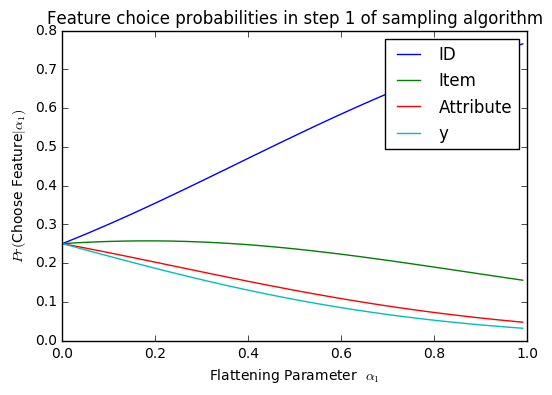

In [9]:
pr_item=[]
pr_id = []
pr_attr=[]
pr_y = []
stdout = sys.stdout
sampled_feature_names = ['item','id','attrs','y']
sys.stdout = open(os.devnull, 'w')
for a in np.arange(0,1,.01):
    tempprobs = implicitsampler.gen_step1_probs(feat2vec_fm,sampled_feature_names,a)
    pr_item.append(tempprobs[sampled_feature_names.index('item')])
    pr_id.append(tempprobs[sampled_feature_names.index('id')])
    pr_attr.append(tempprobs[sampled_feature_names.index('attrs')])
    pr_y.append(tempprobs[sampled_feature_names.index('y')])
sys.stdout = stdout
plt.plot(np.arange(0,1,.01),pr_id,label = 'ID')
plt.plot(np.arange(0,1,.01),pr_item,label = 'Item')
plt.plot(np.arange(0,1,.01),pr_attr,label = 'Attribute')
plt.plot(np.arange(0,1,.01),pr_y,label = 'y')
plt.legend()
plt.xlabel(r'Flattening Parameter  $\alpha_1$')
plt.ylabel(r'$Pr($Choose Feature$ | \alpha_1)$')
plt.title(r'Feature choice probabilities in step 1 of sampling algorithm')
plt.show()

create the probabilities for step1 of our sampler which determines how likely a feature is resampled for producing a negative label. here we choose 

Pr(choose feature $j$) $\propto$ $|j|^{.25}$

where $|j|$ is the number of parameters associated with  of feature $j$

In [10]:
feature_alpha=0.25
step1_probs = implicitsampler.gen_step1_probs(feat2vec_fm,sampled_feature_names,feature_alpha)

--Original Probs--
[ 0.15384615  0.76923077  0.04615385  0.03076923]
--New Probs with alpha=0.25--
[ 0.25613626  0.38301305  0.18956204  0.17128864]


Split data into validation and training data

In [11]:
pct_train = .90
train_sample = np.random.uniform(size=samplesize)
train_sample = (train_sample <=np.percentile(train_sample,pct_train*100) ).astype('bool')
train_data = data[train_sample==True]
valid_data = data[train_sample==False]

Create samplers from implicitsampler class . Here we pass the second main hyperparameter, $\alpha_2=.25$ (sampling_alpha) to determine how much we flatten our empirical distribution that samples values for negative labels.

* sampling_bias adds a minimum count to each unique value in the data to ensure very low frequency values get sampled enough

* negative_samples is the number of negative samples per observed record

* keep_noise_probs necessary if we use NCE, otherwise should not use.

In [12]:
trainsampler = ImplicitSampler(train_data,model_features=model_features,sampling_features=sampling_features,
                          batch_size=batch_size,                 
                          sampling_alpha=.25,sampling_bias=10,
                          negative_samples=neg_samples,
                          init_probs = step1_probs,keep_noise_probs=feat2vec_obj.obj=='nce')
validsampler = ImplicitSampler(valid_data,model_features=model_features,sampling_features=sampling_features,
                          batch_size=batch_size,                 
                          sampling_alpha=.25,sampling_bias=10,
                          negative_samples=neg_samples,
                          init_probs = step1_probs,keep_noise_probs=feat2vec_obj.obj=='nce')

no sampling_items passed; generating unique item sets from df passed
[['item'], ['id'], ['attr1', 'attr2', 'attr3'], ['y']]
generating probs for ['item']
generating probs for ['id']
generating probs for ['attr1', 'attr2', 'attr3']
generating probs for ['y']
calculating prob lookup dict for expedited sampling of negative labels...
no sampling_items passed; generating unique item sets from df passed
[['item'], ['id'], ['attr1', 'attr2', 'attr3'], ['y']]
generating probs for ['item']
generating probs for ['id']
generating probs for ['attr1', 'attr2', 'attr3']
generating probs for ['y']
calculating prob lookup dict for expedited sampling of negative labels...


Finally, fit the model!

In [13]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=0)]
feat2vec_fm.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.TFOptimizer(tf.train.AdamOptimizer()))

feat2vec_fm.fit_generator(generator = trainsampler.keras_generator(),
                          epochs=100, 
                          steps_per_epoch = len(train_data)/batch_size,
                          validation_data=validsampler.keras_generator(),
                          validation_steps =  len(valid_data)/batch_size,
                          callbacks=callbacks,
                          verbose=1,
                          max_queue_size=1,
                          workers=1,
                          use_multiprocessing=True)

Epoch 1/100
45/45 [==============================] - 13s - loss: 2.5036 - acc: 0.2837 - val_loss: 2.0232 - val_acc: 0.3121
Epoch 2/100
45/45 [==============================] - 8s - loss: 2.1061 - acc: 0.4146 - val_loss: 1.4828 - val_acc: 0.4528
Epoch 3/100
45/45 [==============================] - 10s - loss: 1.6233 - acc: 0.6156 - val_loss: 1.1058 - val_acc: 0.7070
Epoch 4/100
45/45 [==============================] - 10s - loss: 1.3844 - acc: 0.7062 - val_loss: 0.9886 - val_acc: 0.7091
Epoch 5/100
45/45 [==============================] - 9s - loss: 1.3066 - acc: 0.7072 - val_loss: 0.9687 - val_acc: 0.7101
Epoch 6/100
45/45 [==============================] - 7s - loss: 1.2798 - acc: 0.7063 - val_loss: 0.9783 - val_acc: 0.7130


# Example Usage : Look at cosine similarity of embeddings

In [14]:
#collect embeddings
embeddings = []
embed_names = ['dim_'+str(i) for i in range(1,embed_dim+1)]
for j in feat2vec_obj.feature_names:
    for l in feat2vec_fm.layers:
         if l.name=='factor_{}'.format(j) or l.name=='embedding_{}'.format(j):
                embedding = feat2vec_fm.get_layer(l.name).get_weights()[0]
                embedding = pd.DataFrame(embedding,columns=embed_names)
                embedding['value'] = [j +'_' + str(i) for i in embedding.index]
                embeddings.append(embedding)
embeddings = pd.concat(embeddings,ignore_index=True)

In [15]:
def kNN_embeddings(value,k):
    embedding = embeddings.loc[embeddings['value']==value,embed_names]
    scores = np.dot(embeddings[embed_names],embedding.T).flatten()
    scores = np.array([s/(np.linalg.norm(embedding)*np.linalg.norm(embeddings.loc[i,embed_names])) for i,s in enumerate(scores)]).flatten()
    temp = np.argsort(-scores)
    ranks = np.empty(len(scores), int)
    ranks[temp] = np.arange(len(scores))
    for r in range(1,k+1):
        print embeddings.loc[ranks==r,'value'].values,scores[ranks==r]

Check out what the closest embeddings are to ID#5

In [16]:
kNN_embeddings('id_5',5)

['id_35'] [ 0.94209772]
['id_25'] [ 0.92919123]
['id_24'] [ 0.9254151]
['id_15'] [ 0.92391348]
['id_29'] [ 0.92253888]


In [17]:
kNN_embeddings('id_5',5)

['id_35'] [ 0.94209772]
['id_25'] [ 0.92919123]
['id_24'] [ 0.9254151]
['id_15'] [ 0.92391348]
['id_29'] [ 0.92253888]


It learned that $mod(10)$ IDs by the same items and have similar y!